In [12]:
!nvidia-smi

Mon Sep 21 14:14:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   2403MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image, ImageFile

In [14]:
# fix random seed for reproducibility
seed = 50000
np.random.seed(seed)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
path = './drive/My Drive/data_complete/train'
train_datagen = ImageDataGenerator(rescale=1. / 255)
batch_size = 32

In [17]:
train = train_datagen.flow_from_directory(path, target_size=(224, 224),batch_size=batch_size,class_mode=None)
#train = train_datagen.flow_from_directory(path, target_size=(256, 256),class_mode=None) #takes a default batch size of 32

Found 99977 images belonging to 10 classes.


In [18]:
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128)
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

(32, 224, 224, 1)
(32, 224, 224, 2)


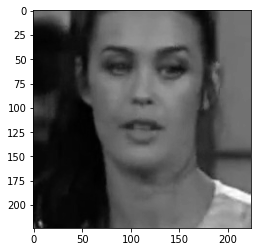

In [19]:
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(X[10]), cmap='gray')

In [20]:
#Encoder
encoder_input = Input(shape=(224, 224, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = BatchNormalization()(encoder_output)
#encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
#encoder_output = BatchNormalization()(encoder_output)
#encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
#encoder_output = BatchNormalization()(encoder_output)
#encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
#encoder_output = BatchNormalization()(encoder_output)
#encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
#encoder_output = BatchNormalization()(encoder_output)
#encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
#encoder_output = BatchNormalization()(encoder_output)
#encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
#encoder_output = BatchNormalization()(encoder_output)
#encoder_output = Dropout(0.5)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
#encoder_output = BatchNormalization()(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
#decoder_output = BatchNormalization()(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
#decoder_output = BatchNormalization()(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
#decoder_output = BatchNormalization()(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
#decoder_output = BatchNormalization()(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
#decoder_output = BatchNormalization()(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)      

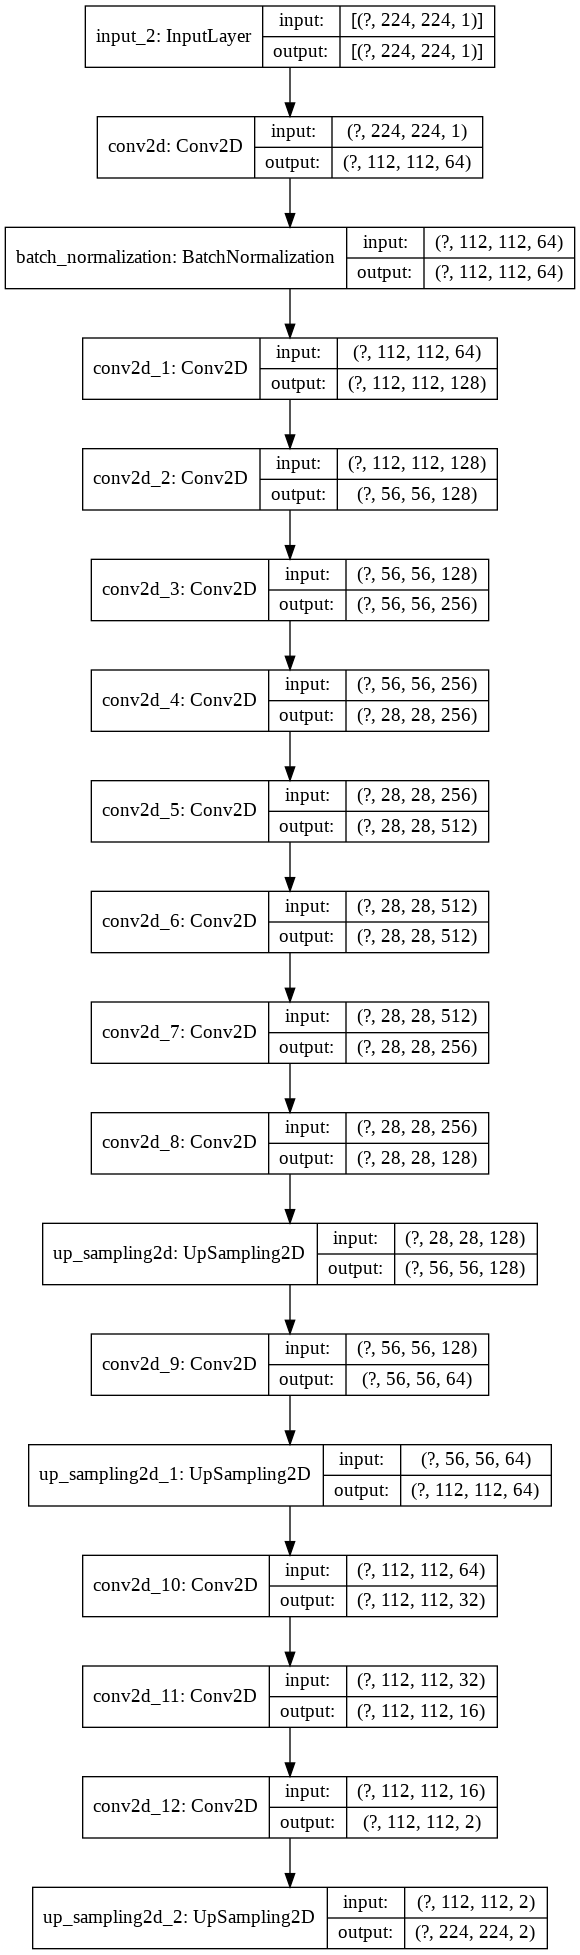

In [22]:
keras.utils.plot_model(model, "Colorization_AE.png", show_shapes=True)

In [23]:
# define SGD optimizer
sgd = keras.optimizers.SGD(lr=0.0005, momentum=0.4, decay=1e-6, nesterov=False) 

# define ADAM optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-5)

model.compile(optimizer=opt, loss='mse' , metrics=['accuracy'])
history = model.fit(X,Y,validation_split=0.2, batch_size=batch_size, epochs=1000)
test_scores = model.evaluate(X, Y, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Epoch 1/1000
1/1 [==============================] - 1s 556ms/step - loss: 0.0202 - accuracy: 0.3309 - val_loss: 0.6446 - val_accuracy: 0.3401
Epoch 2/1000
1/1 [==============================] - 0s 163ms/step - loss: 0.2964 - accuracy: 0.3414 - val_loss: 0.0219 - val_accuracy: 0.3256
Epoch 3/1000
1/1 [==============================] - 0s 162ms/step - loss: 0.0209 - accuracy: 0.3306 - val_loss: 0.0112 - val_accuracy: 0.3266
Epoch 4/1000
1/1 [==============================] - 0s 158ms/step - loss: 0.0176 - accuracy: 0.3325 - val_loss: 0.0087 - val_accuracy: 0.3283
Epoch 5/1000
1/1 [==============================] - 0s 159ms/step - loss: 0.0162 - accuracy: 0.3344 - val_loss: 0.0244 - val_accuracy: 0.3262
Epoch 6/1000
1/1 [==============================] - 0s 158ms/step - loss: 0.0145 - accuracy: 0.3324 - val_loss: 0.0802 - val_accuracy: 0.3262
Epoch 7/1000
1/1 [==============================] - 0s 159ms/step - loss: 0.0144 - accuracy: 0.3335 - val_loss: 0.0117 - val_accuracy: 0.3272
Epoch 

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


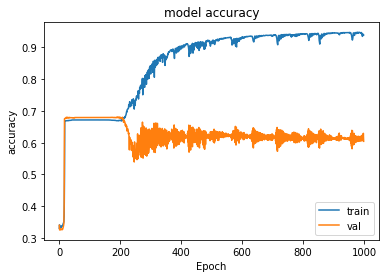

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

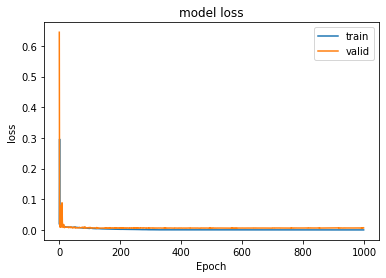

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [27]:
test_path = './drive/My Drive/Colorization/'
test = os.listdir(test_path)
for imgName in test:
  color_me = []
  img = img_to_array(load_img(test_path + imgName))
  img = resize(img ,(224,224))
  color_me.append(img)
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))
print(color_me.shape)

(1, 224, 224, 1)


In [28]:
output = model.predict(color_me)
output = output * 128

In [29]:
# Output colorizations
for i in range(len(output)):
    result = np.zeros((224, 224, 3))
    result[:,:,0] = color_me[i][:,:,0]
    result[:,:,1:] = output[i]
    imsave("Result_Original_Dataset"+str(i)+".png", lab2rgb(result))

In [30]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X[10].reshape(1,224,224,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index])
            #ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

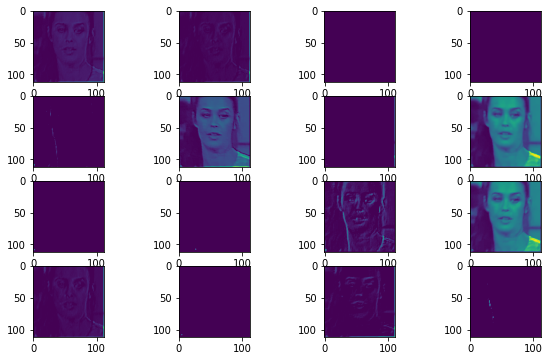

In [31]:
display_activation(activations, 4, 4, 1) #Layer 2

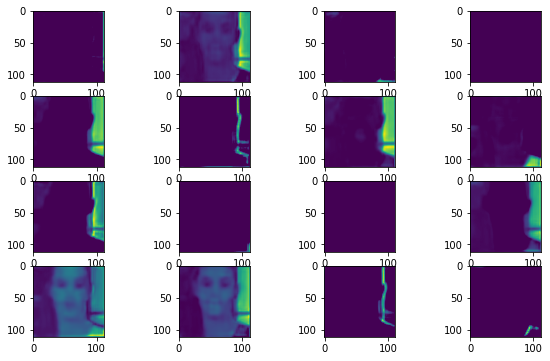

In [32]:
display_activation(activations, 4, 4, 15) #Layer 16

# **Transfer Learning**

In [33]:
vggmodel = keras.applications.vgg16.VGG16()
newmodel = Sequential() 
num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [34]:
#train = train_datagen.flow_from_directory(path, target_size=(224, 224),batch_size=batch_size,class_mode=None)
train = train_datagen.flow_from_directory(path, target_size=(224, 224),class_mode=None)

Found 99977 images belonging to 10 classes.


In [35]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(32, 7, 7, 512)


In [36]:
#Encoder
encoder_input = Input(shape=(7, 7, 512,))
#Decoder
decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model2 = Model(inputs=encoder_input, outputs=decoder_output)

In [37]:
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 7, 7, 512)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)       

In [38]:
model2.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model2.fit(vggfeatures, Y, verbose=1, epochs=1000, batch_size=32)

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.3874 - accuracy: 0.5000
Epoch 2/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.7227 - accuracy: 0.5060
Epoch 3/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5473 - accuracy: 0.6197
Epoch 4/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6758 - accuracy: 0.6637
Epoch 5/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.7781 - accuracy: 0.6541
Epoch 6/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.7287 - accuracy: 0.6650
Epoch 7/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.6703 - accuracy: 0.6639
Epoch 8/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.5514 - accuracy: 0.6578
Epoch 9/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5812 - accuracy: 0.6484
Epoch 10/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5234 - accuracy: 0.6527
Epoch 11/1000
1

In [39]:
test_path = './drive/My Drive/Colorization/'
files = os.listdir(test_path)
for idx, file in enumerate(files):
    test = img_to_array(load_img(test_path+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model2.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    imsave("Result_Transfer_Learning"+str(idx)+".png", lab2rgb(cur))